<a href="https://colab.research.google.com/github/eodnsl41/abcd/blob/main/preprocessing(_ing).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Pulsar-kkaturi/DL-Education.git

Cloning into 'DL-Education'...
remote: Enumerating objects: 452, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 452 (delta 4), reused 1 (delta 1), pack-reused 445
Receiving objects: 100% (452/452), 38.98 MiB | 16.20 MiB/s, done.
Resolving deltas: 100% (201/201), done.


# 1. Library Import

In [2]:
!pip install simpleitk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52.8 MB 187 kB/s 


In [4]:
import numpy as np
import os
import matplotlib
from matplotlib import pyplot as pyplot
from matplotlib.ticker import MultipleLocator
import SimpleITK as sitk
import json
import csv
import pandas as pd
from sklearn import metrics as skmet
from skimage import morphology
from skimage import measure
from skimage import exposure
from skimage.transform import rotate
import cv2 as cv2
from keras.preprocessing import image as kimg

import matplotlib.pyplot as plt

# 2. Data Loading

# Header Information #
Image Size =  (512, 512, 1)
Pixel Spacing =  (0.646484375, 0.646484375, 1.0)
Image Dimension =  3
Number of Pixel Components =  1
Minimum & Maximum pixel value(Min/Max) = -1000/1844
Image mean & std = -555.9083557128906, 518.929847210932


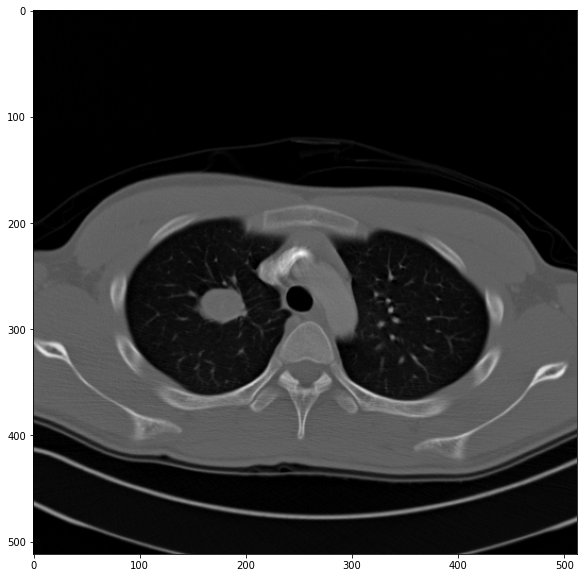

In [6]:
test_data = '/content/test.dcm'
image = sitk.ReadImage(test_data)
img_arr = sitk.GetArrayFromImage(image)
print('# Header Information #')
print('Image Size = ', image.GetSize())
print('Pixel Spacing = ', image.GetSpacing())
print('Image Dimension = ', image.GetDimension())
print('Number of Pixel Components = ', image.GetNumberOfComponentsPerPixel())
print('Minimum & Maximum pixel value(Min/Max) = {}/{}'.format(np.min(img_arr), np.max(img_arr)))
print('Image mean & std = {}, {}'.format(np.mean(img_arr), np.std(img_arr)))

plt.figure(figsize=(10, 10))
plt.imshow(img_arr[0], cmap='gray')

# 3. Basic Pre-Processing

# 3.1 Resize

Original Image Size = (512, 512, 1)
Processed Image Size = (256, 256, 1)
Original Pixel Spacing = (0.646484375, 0.646484375, 1.0)
Processed Pixel Spacing = (1.29296875, 1.29296875, 1.0)


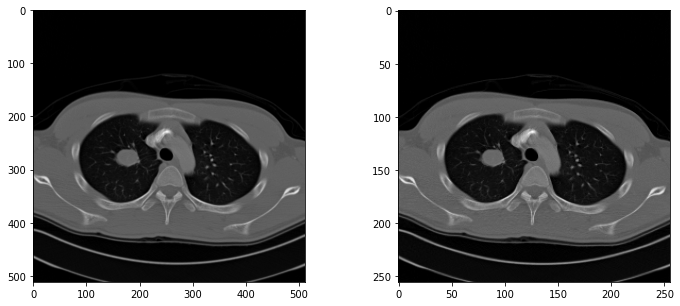

In [8]:
# Resize

#image = sitk.ReadImage(test_data)
#img_arr = sitk.GetArrayFromImage(image)

def resize_array(sitk_image, size, interpolator = sitk.sitkLinear):
    original_spacing = sitk_image.GetSpacing()
    original_size = sitk_image.GetSize()
    new_size = list(original_size)
    new_size[0]=size[0]
    new_size[1]=size[1]
    new_spacing = [(ospc * osz / nsz) for osz, ospc, nsz in 
                   zip(original_size, original_spacing, new_size)]

    sitk_image = sitk.Resample(sitk_image, new_size, sitk.Transform(), interpolator, 
                               sitk_image.GetOrigin(), new_spacing, sitk_image.GetDirection(),
                               0, sitk_image.GetPixelID())
    return sitk_image

resize_img = resize_array(image, [256, 256])
print('Original Image Size =', image.GetSize())
print('Processed Image Size =', resize_img.GetSize())
print('Original Pixel Spacing =', image.GetSpacing())
print('Processed Pixel Spacing =', resize_img.GetSpacing())

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.imshow(img_arr[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(sitk.GetArrayFromImage(resize_img)[0], cmap='gray')

# 3.2 Resample

Original Pixel Spacing = (0.646484375, 0.646484375, 1.0)
Processed Pixel Spacing = (1.0, 1.0, 1.0)
Original Image Size = (512, 512, 1)
Processed Image Size = (331, 331, 1)


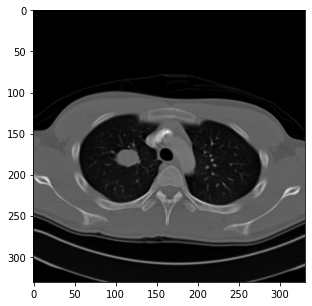

In [11]:
# Resample

def resample_array(sitk_image, spacing, interpolator= sitk.sitkLinear):
    original_spacing = sitk_image.GetSpacing()
    original_size = sitk_image.GetSize()
    new_spacing = [spacing, spacing, original_spacing[2]]
    new_size = [int(round(osz * ospc / nspc)) for osz, ospc, nspc in
                zip(original_size, original_spacing, new_spacing)]
    sitk_image = sitk.Resample(sitk_image, new_size, sitk.Transform(), interpolator,
                               sitk_image.GetOrigin(), new_spacing, sitk_image.GetDirection(),
                               0, sitk_image.GetPixelID())
    return sitk_image

resample_img = resample_array(image, 1)
print('Original Pixel Spacing =', image.GetSpacing())
print('Processed Pixel Spacing =', resample_img.GetSpacing())
print('Original Image Size =', image.GetSize())
print('Processed Image Size =', resample_img.GetSize())

plt.figure(figsize=(12,5))
plt.subplot(2,1,1)
plt.imshow(img_arr[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(sitk.GetArrayFromImage(resample_img)[0], cmap='gray')

# 3.3 Min-Max Normalization

Original Image min/max value = -1000/1844
Processed Image min/max value = 0.0/1.0

Sample Patch Comparison(Orinal vs Processed)
[[144 141 114 109  94]
 [201 171 152 139 110]
 [396 309 242 179 153]
 [508 519 439 353 328]
 [375 430 452 463 476]]
[[0.40225035 0.4011955  0.39170183 0.38994374 0.38466948]
 [0.42229255 0.41174402 0.40506329 0.40049226 0.39029536]
 [0.49085795 0.46026723 0.43670886 0.41455696 0.40541491]
 [0.5302391  0.53410689 0.5059775  0.4757384  0.46694796]
 [0.48347398 0.50281294 0.51054852 0.51441632 0.51898734]]


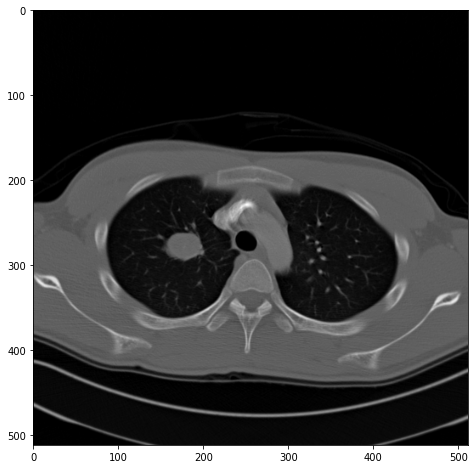

In [16]:
# MinMax Normalization

norm_img = (img_arr - np.min(img_arr)) / (np.max(img_arr) - np.min(img_arr))
print('Original Image min/max value = {}/{}'.format(np.min(img_arr), np.max(img_arr)))
print('Processed Image min/max value = {}/{}'.format(np.min(norm_img), np.max(norm_img)))
print('\nSample Patch Comparison(Orinal vs Processed)')
print(img_arr[0, 185:190, 275:280])
print(norm_img[0, 185:190, 275:280])

plt.figure(figsize=(8,8))
plt.imshow(norm_img[0], cmap='gray')

# 3.4 Z-score Normalization

Original Image min/max value = -1000/1844
Processed Image min/max value = -0.8557835836075877/4.62472599834364
Original Image mean/std value = -555.9083557128906/518.929847210932
Processed Image mean/std value = -1.1102230246251565e-16/0.9999999999999999

Sample Patch Comparison(Origin vs Processed)
[[144 141 114 109  94]
 [201 171 152 139 110]
 [396 309 242 179 153]
 [508 519 439 353 328]
 [375 430 452 463 476]]
[[1.34875332 1.34297219 1.29094204 1.28130683 1.25240119]
 [1.45859476 1.40078348 1.36416966 1.33911811 1.28323387]
 [1.8343681  1.66671538 1.53760351 1.41619982 1.36609671]
 [2.05019688 2.07139435 1.91723093 1.75150526 1.70332919]
 [1.7939002  1.89988755 1.94228249 1.96347996 1.98853152]]


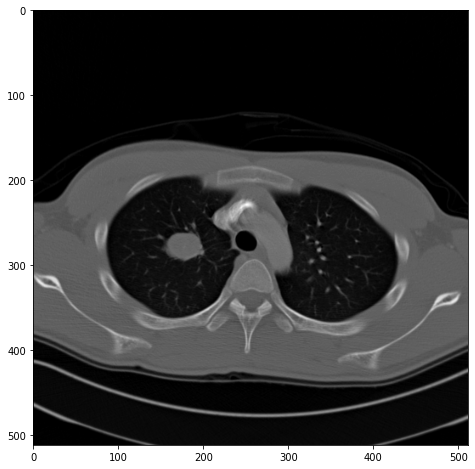

In [17]:
# Z-score Normalization

zsc_img = (img_arr - np.mean(img_arr)) / np.std(img_arr)
print('Original Image min/max value = {}/{}'.format(np.min(img_arr), np.max(img_arr)))
print('Processed Image min/max value = {}/{}'.format(np.min(zsc_img), np.max(zsc_img)))
print('Original Image mean/std value = {}/{}'.format(np.mean(img_arr), np.std(img_arr)))
print('Processed Image mean/std value = {}/{}'.format(np.mean(zsc_img), np.std(zsc_img)))
print('\nSample Patch Comparison(Origin vs Processed)')
print(img_arr[0, 185:190, 275:280])
print(zsc_img[0, 185:190, 275:280])

plt.figure(figsize=(8,8))
plt.imshow(zsc_img[0], cmap='gray')

# 3.5 Gamma Correction

Original Image mean/max value = 39.81834363333788/255.0
Processed Image mean/max value = 4.718105527925476/4.19020570625082


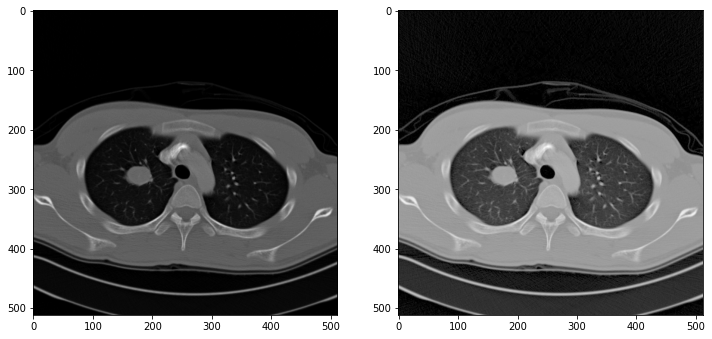

In [18]:
# Gamma Correction

gamma_cor = exposure.adjust_gamma(255*norm_img, 0.5)
print('Original Image mean/max value = {}/{}'.format(np.mean(255*norm_img), np.max(255*norm_img)))
print('Processed Image mean/max value = {}/{}'.format(np.mean(gamma_cor), np.std(gamma_cor)))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img_arr[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(gamma_cor[0], cmap='gray')

# 3.6 Adaptive Equalization

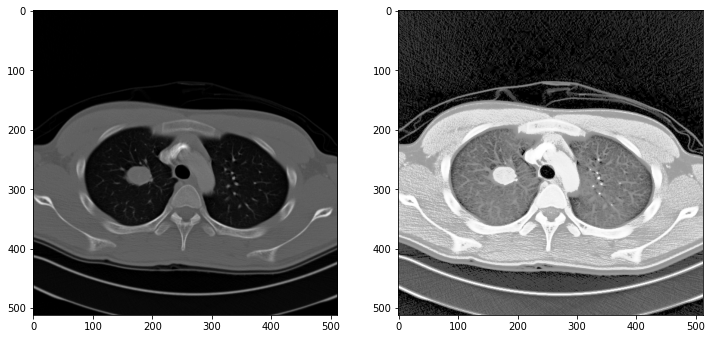

In [22]:
# Adaptive Equalization

img_eqh = exposure.equalize_hist(img_arr)

plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.imshow(img_arr[0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(img_eqh[0], cmap='gray')

# 4. Hounsfield Unit Lung Area Segmentation

# 4.1 Hu Conversion

In [24]:
itc = image.GetMetaData('0028|1052')
slp = image.GetMetaData('0028|1053')
#print('Rescale Slope (0028|1053) = ', image.GetMetaData('0028|1053'))
#print('Rescale Intercept (0028|1052) =', image.GetMetaData('0028|1052'))
print('Rescale Slope (0028|1053) = ', slp)
print('Rescale Intercept (0028|1052) =', itc)

Rescale Slope (0028|1053) =  1.
Rescale Intercept (0028|1052) = -1000.


(1, 512, 512) (1, 512, 512)
original = -1000 1844
HU conversion =  -2000.0 844.0


Text(0.5, 1.0, 'HU conversion')

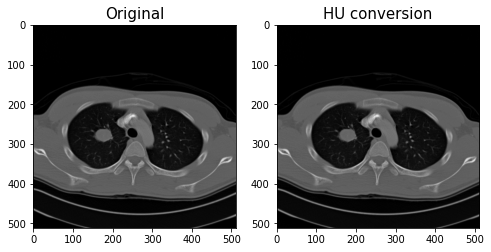

In [25]:
img_arr_hu = (img_arr * float(slp)) + float(itc)
print(img_arr.shape, img_arr_hu.shape)
print('original =', np.min(img_arr), np.max(img_arr))
print('HU conversion = ', np.min(img_arr_hu), np.max(img_arr_hu))
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(img_arr[0], cmap='gray')
plt.title('Original', fontsize=15)
plt.subplot(1,2,2)
plt.imshow(img_arr_hu[0], cmap='gray')
plt.title('HU conversion', fontsize=15)

# 4.2 WIndow Setting

Text(0.5, 1.0, 'Window Setting')

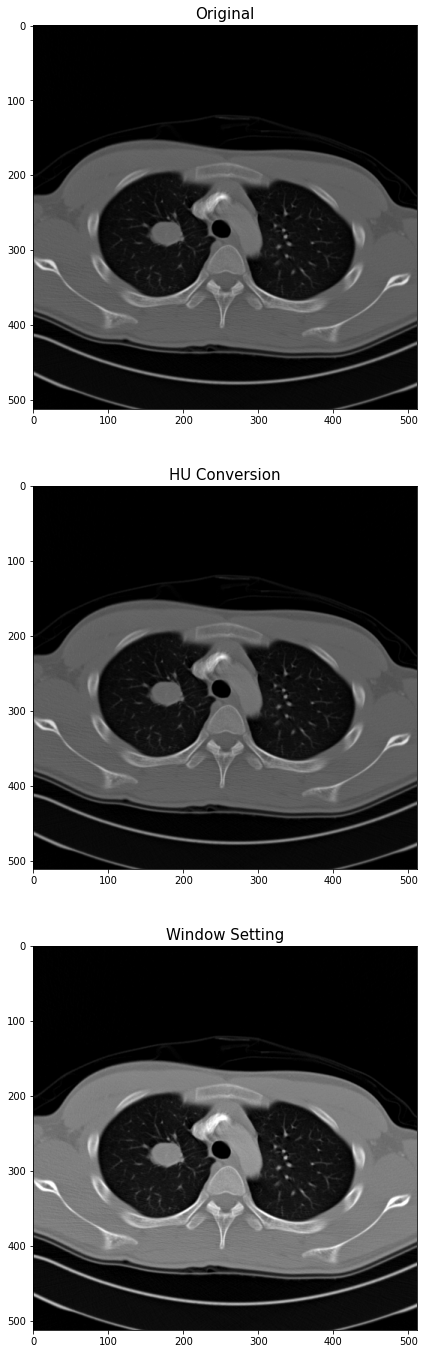

In [26]:
#img_arr_hu = (img_arr * float(slp)) + float(itc)

img_arr_win1 = np.where(img_arr_hu < -2000, -2000, img_arr_hu)
img_arr_win = np.where(img_arr_win1 > 150, 150, img_arr_win1)

plt.figure(figsize=(12, 24))

plt.subplot(3,1,1)
plt.imshow(img_arr[0], cmap='gray')
plt.title('Original', fontsize=15)

plt.subplot(3,1,2)
plt.imshow(img_arr_hu[0], cmap='gray')
plt.title('HU Conversion', fontsize=15)

plt.subplot(3,1,3)
plt.imshow(img_arr_win[0], cmap='gray')
plt.title('Window Setting', fontsize=15)


# 4.3 Make Mask

0 1


Text(0.5, 1.0, 'Threshold')

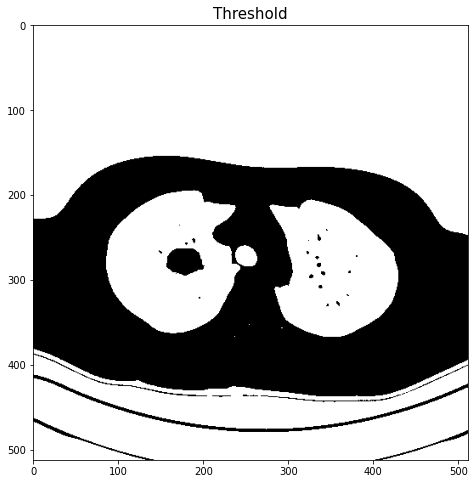

In [27]:
# Thresholding
img_arr_thres = np.where(img_arr_win < -1200, 1, 0)
print(np.min(img_arr_thres), np.max(img_arr_thres))

plt.figure(figsize=(8,8))
plt.imshow(img_arr_thres[0], cmap='gray')
plt.title('Threshold', fontsize=15)

Text(0.5, 1.0, 'Eroded')

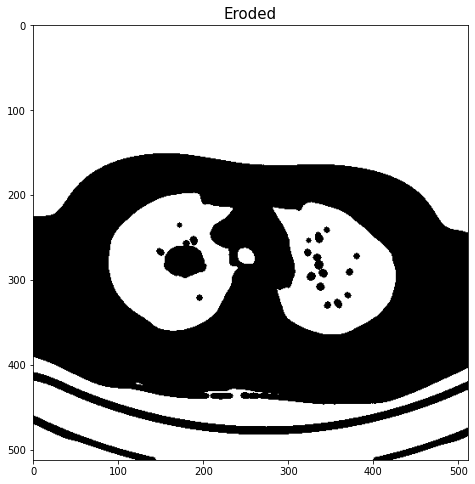

In [28]:
# Erosion

#img_arr_thres = np.where(img_arr_win < -1200, 1, 0)

eroded = morphology.erosion(img_arr_thres[0], morphology.disk(3))

plt.figure(figsize=(8,8))
plt.imshow(eroded, cmap='gray')
plt.title('Eroded', fontsize=15)

Text(0.5, 1.0, 'Dilation')

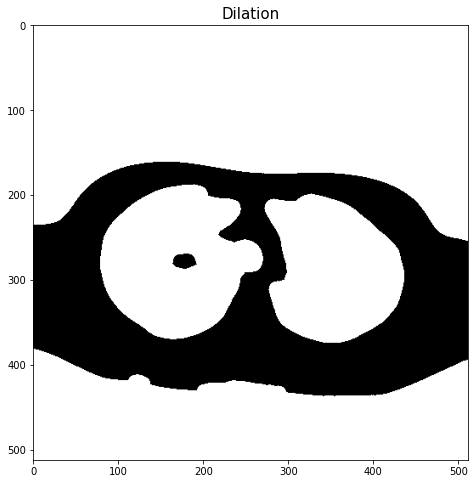

In [29]:
# Dilation
#img_arr_thres = np.where(img_arr_win < -1200, 1, 0)
#eroded = morphology.erosion(img_arr_thres[0], morphology.disk(3))

dilation = morphology.dilation(eroded, morphology.disk(10))

plt.figure(figsize=(8,8))
plt.imshow(dilation, cmap='gray')
plt.title('Dilation', fontsize=15)

Text(0.5, 1.0, 'closing')

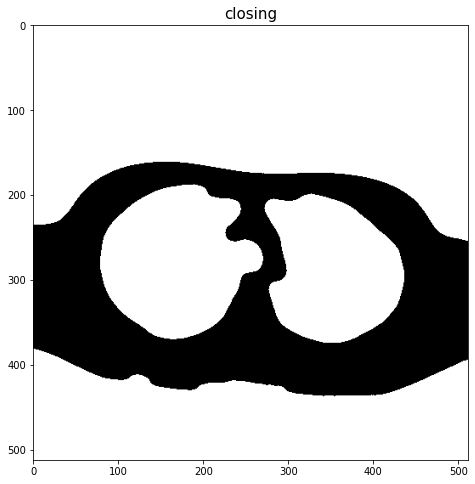

In [30]:
#Closing
#img_arr_thres = np.where(img_arr_win < -1200, 1, 0)
#eroded = morphology.erosion(img_arr_thres[0], morphology.disk(3))
#dilation = morphology.dilation(eroded, morphology.disk(10))

closing  = morphology.closing(dilation, morphology.disk(10))

plt.figure(figsize=(8,8))
plt.imshow(closing, cmap='gray')
plt.title('closing', fontsize=15)

Text(0.5, 1.0, 'Color labels')

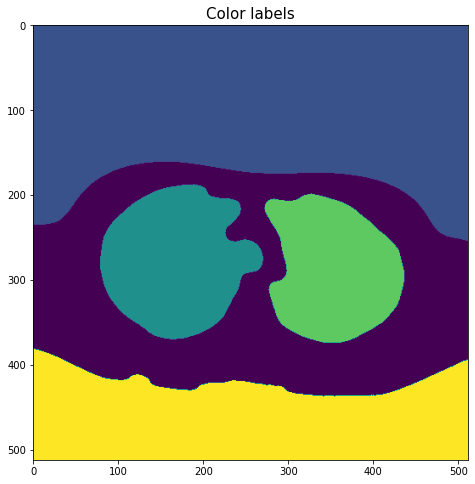

In [31]:
# color label

#img_arr_thres = np.where(img_arr_win < -1200, 1, 0)
#eroded = morphology.erosion(img_arr_thres[0], morphology.disk(3))
#dilation = morphology.dilation(eroded, morphology.disk(10))
#closing  = morphology.closing(dilation, morphology.disk(10))

labels = measure.label(closing)
show_lab = np.where(labels==0,1,0)

plt.figure(figsize=(8,8))
plt.imshow(labels, cmap='viridis')
plt.title('Color labels', fontsize= 15)

4
0 1


Text(0.5, 1.0, 'Final Mask')

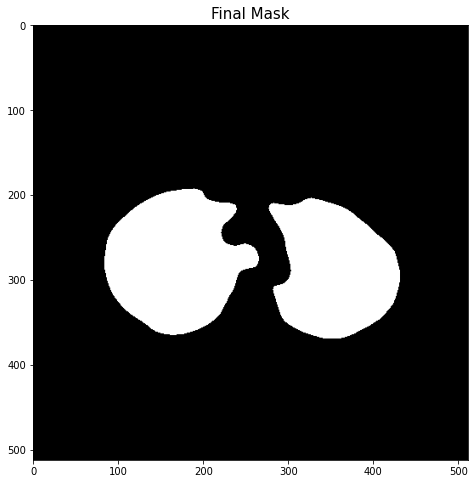

In [35]:
#find good label

#노이해

print(np.max(labels))
row_size = labels.shape[0]
col_size = labels.shape[1]

regions = measure.regionprops(labels)

good_labels = []

for prop in regions:
    B = prop.bbox
    if B[2]-B[0]<row_size*0.9 and B[3]-B[1] < col_size*0.9 and B[0]>row_size*0.1 and B[2]>col_size*0.1 :
        good_labels.append(prop.label)

mask = np.zeros(shape=(row_size, col_size), dtype=np.int8)

for N in good_labels:
    mask = mask + np.where(labels == N,1,0)

mask = morphology.dilation(mask, morphology.disk(5)) #mask = np.where(labels == 0,1,0)
mask = morphology.closing(mask, morphology.disk(5))
mask = morphology.erosion(mask, morphology.disk(10))

print(np.min(mask), np.max(mask))
plt.figure(figsize=(8,8))
plt.imshow(mask, cmap='gray')
plt.title('Final Mask', fontsize=15)

# 4.4 Lung Area Segmentation

# 5. Data Augmentation